# Stepwise exercise on TensorFlow's code example on Word2Vec algorithm

[source code](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/word2vec/word2vec_basic.py)

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import collections
import math
import os
import random
import sys
from tempfile import gettempdir
import zipfile

import numpy as np
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf

from tensorflow.contrib.tensorboard.plugins import projector

data_index = 0


In [2]:
tf.__version__

'1.14.0'

#### break the source code into chunks

In [3]:
log_dir = '../log'

"""Example of building, training and visualizing a word2vec model."""
# Create the directory for TensorBoard variables if there is not.
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# Step 1: Download the data.
url = 'http://mattmahoney.net/dc/'

## step 1: download the raw data

In [4]:
gettempdir()

'/var/folders/_r/1t3rxwvj54l7tk0jrx5r2j640000gq/T'

In [5]:
# pylint: disable=redefined-outer-name
def maybe_download(filename, expected_bytes):
    """Download a file if not present, and make sure it's the right size."""
    local_filename = os.path.join(gettempdir(), filename)
    if not os.path.exists(local_filename):
        local_filename, _ = urllib.request.urlretrieve(url + filename,
                                                       local_filename)
    statinfo = os.stat(local_filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', filename)
    else:
        print(statinfo.st_size)
        raise Exception('Failed to verify ' + local_filename +
                      '. Can you get to it with a browser?')
    return local_filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


In [6]:
filename

'/var/folders/_r/1t3rxwvj54l7tk0jrx5r2j640000gq/T/text8.zip'

## step 2: Read the data into a list of strings.

In [7]:
def read_data(filename):
    """Extract the first file enclosed in a zip file as a list of words."""
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data

vocabulary = read_data(filename)
print('Data size', len(vocabulary))

Data size 17005207


In [8]:
type(vocabulary)

list

In [9]:
vocabulary[:5]

['anarchism', 'originated', 'as', 'a', 'term']

In [10]:
len(set(vocabulary)) ## 253,854 unique words

253854

## step 3: Build the dictionary and replace rare words with UNK token.

In [11]:
words = vocabulary
n_words = 50000

count = [['UNK', -1]]
count.extend(collections.Counter(words).most_common(n_words - 1))
count[:5]

[['UNK', -1],
 ('the', 1061396),
 ('of', 593677),
 ('and', 416629),
 ('one', 411764)]

In [12]:
dictionary = {}
for word, _ in count:
    dictionary[word] = len(dictionary)
dictionary['UNK'], dictionary['the'], dictionary['of']

(0, 1, 2)

#### put all together

In [13]:
vocabulary_size = 50000

def build_dataset(words, n_words):
    """Process raw inputs into a dataset."""
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(n_words - 1)) # get top 50k words in frequency
    dictionary = {}
    for word, _ in count:
        dictionary[word] = len(dictionary) # index those top words by frequency ranking
    data = []
    unk_count = 0
    for word in words:
        index = dictionary.get(word, 0)
        if index == 0:  # dictionary['UNK']
            unk_count += 1
        data.append(index) # collect indices of all words
    count[0][1] = unk_count # update the UNK count, which is everything else except top 50k-1
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reversed_dictionary

  # Filling 4 global variables:
# data - list of codes (integers from 0 to vocabulary_size-1).
#   This is the original text but words are replaced by their codes
# count - map of words(strings) to count of occurrences
# dictionary - map of words(strings) to their codes(integers)
# reverse_dictionary - maps codes(integers) to words(strings)
data, count, unused_dictionary, reverse_dictionary = build_dataset(
  vocabulary, vocabulary_size)
del vocabulary  # Hint to reduce memory.
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156] ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


## step 4: Function to generate a training batch for the skip-gram model.

In [14]:
data_index=0
data2 = data[:5].copy()

In [15]:
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    print('data_index: {}'.format(data_index))
    print('length of data: {}'.format(len(data2)))
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    print('original batch: {}'.format(batch))
    print('original labels: {}'.format(labels))
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    print('span: {}'.format(span))
    ## create a double ended queue representing the range of [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)  # pylint: disable=redefined-builtin
    if data_index + span > len(data2):
        data_index = 0 ## what does this do??
    buffer.extend(data2[data_index:data_index + span])
    print('buffer: {}'.format(buffer))
    data_index += span
    for i in range(batch_size // num_skips):
        context_words = [w for w in range(span) if w != skip_window]
        print('iteration {}, context words: {}'.format(i, context_words))
        words_to_use = random.sample(context_words, num_skips) # num of context words to use
        print('iteration {}, words to use: {}'.format(i, words_to_use))
        for j, context_word in enumerate(words_to_use):
            batch[i * num_skips + j] = buffer[skip_window] # the target word??
            labels[i * num_skips + j, 0] = buffer[context_word] # the context words??
        print('iteration {}, batch: {}'.format(i, batch))
        print('iteration {}, labels: {}'.format(i, labels))
        if data_index == len(data2): # get to the end of the data, start over again
            buffer.extend(data2[0:span])
            data_index = span
        else:
            buffer.append(data2[data_index]) # move the buffer window by 1 unit
            data_index += 1
        print('new buffer: {}'.format(buffer))
        print('data_index: {}'.format(data_index))
    # Backtrack a little bit to avoid skipping words in the end of a batch
    data_index = (data_index + len(data2) - span) % len(data2)
    print('Finally, data_index: {}'.format(data_index))
    return batch, labels

batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
# for i in range(8):
#     print(batch[i], reverse_dictionary[batch[i]], '->', labels[i, 0],
#           reverse_dictionary[labels[i, 0]])

data_index: 0
length of data: 5
original batch: [          0 -2147483648   506180475  -536868870 -1840119806       32767
   506182379      133114]
original labels: [[          0]
 [-2147483648]
 [  506183825]
 [-1342175238]
 [ -491061246]
 [      32673]
 [         12]
 [     131369]]
span: 3
buffer: deque([5234, 3081, 12], maxlen=3)
iteration 0, context words: [0, 2]
iteration 0, words to use: [2, 0]
iteration 0, batch: [       3081        3081   506180475  -536868870 -1840119806       32767
   506182379      133114]
iteration 0, labels: [[         12]
 [       5234]
 [  506183825]
 [-1342175238]
 [ -491061246]
 [      32673]
 [         12]
 [     131369]]
new buffer: deque([3081, 12, 6], maxlen=3)
data_index: 4
iteration 1, context words: [0, 2]
iteration 1, words to use: [2, 0]
iteration 1, batch: [       3081        3081          12          12 -1840119806       32767
   506182379      133114]
iteration 1, labels: [[        12]
 [      5234]
 [         6]
 [      3081]
 [-491061246]

In [16]:
(4+17005207-3)%17005207

1

In [17]:
print('Finally, batch: {}'.format(batch))
print('Finally, labels: {}'.format(labels))
print('data_index: {}'.format(data_index))

Finally, batch: [3081 3081   12   12    6    6 3081 3081]
Finally, labels: [[  12]
 [5234]
 [   6]
 [3081]
 [ 195]
 [  12]
 [  12]
 [5234]]
data_index: 1


In [18]:
data[:15]

[5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156, 128, 742, 477, 10572, 134]

#### put it all together

In [19]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    # print('data_index: {}'.format(data_index))
    # print('length of data: {}'.format(len(data)))
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    # print('original batch: {}'.format(batch))
    # print('original labels: {}'.format(labels))
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    # print('span: {}'.format(span))
    ## create a double ended queue representing the range of [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)  # pylint: disable=redefined-builtin
    if data_index + span > len(data):
        data_index = 0 ## what does this do??
    buffer.extend(data[data_index:data_index + span])
    # print('buffer: {}'.format(buffer))
    data_index += span
    for i in range(batch_size // num_skips):
        context_words = [w for w in range(span) if w != skip_window]
        # print('iteration {}, context words: {}'.format(i, context_words))
        words_to_use = random.sample(context_words, num_skips) # num of context words to use
        # print('iteration {}, words to use: {}'.format(i, words_to_use))
        for j, context_word in enumerate(words_to_use):
            batch[i * num_skips + j] = buffer[skip_window] # the target word??
            labels[i * num_skips + j, 0] = buffer[context_word] # the context words??
        # print('iteration {}, batch: {}'.format(i, batch))
        # print('iteration {}, labels: {}'.format(i, labels))
        if data_index == len(data): # get to the end of the data, start over again
            buffer.extend(data[0:span])
            data_index = span
        else:
            buffer.append(data[data_index]) # move the buffer window by 1 unit
            data_index += 1
        # print('new buffer: {}'.format(buffer))
        # print('data_index: {}'.format(data_index))
    # Backtrack a little bit to avoid skipping words in the end of a batch
    data_index = (data_index + len(data) - span) % len(data)
    # print('Finally, data_index: {}'.format(data_index))
    return batch, labels

batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
for i in range(8):
    print(batch[i], reverse_dictionary[batch[i]], '->', labels[i, 0],
          reverse_dictionary[labels[i, 0]])

3081 originated -> 12 as
3081 originated -> 5234 anarchism
12 as -> 6 a
12 as -> 3081 originated
6 a -> 12 as
6 a -> 195 term
195 term -> 2 of
195 term -> 6 a


## step 5: Build and train a skip-gram model.

In [20]:
valid_size = 16  # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
np.random.choice(valid_window, valid_size, replace=False)

array([99, 87, 79,  2, 59, 12, 76, 71,  4, 96,  1, 48, 78, 22, 19, 86])

In [21]:
batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1  # How many words to consider left and right.
num_skips = 2  # How many times to reuse an input to generate a label.
num_sampled = 64  # Number of negative examples to sample.

# We pick a random validation set to sample nearest neighbors. Here we limit
# the validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. These 3 variables are used only for
# displaying model accuracy, they don't affect calculation.
valid_size = 16  # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

graph = tf.Graph()

with graph.as_default():

    # Input data.
    with tf.name_scope('inputs'):
        train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
        train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
        valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Ops and variables pinned to the CPU because of missing GPU implementation
    with tf.device('/cpu:0'):
        # Look up embeddings for inputs.
        with tf.name_scope('embeddings'):
            embeddings = tf.Variable(
                tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
            embed = tf.nn.embedding_lookup(embeddings, train_inputs)

        # Construct the variables for the NCE loss
        with tf.name_scope('weights'):
            nce_weights = tf.Variable(
                tf.truncated_normal([vocabulary_size, embedding_size],
                                    stddev=1.0 / math.sqrt(embedding_size)))
        with tf.name_scope('biases'):
            nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # Compute the average NCE loss for the batch.
    # tf.nce_loss automatically draws a new sample of the negative labels each
    # time we evaluate the loss.
    # Explanation of the meaning of NCE loss:
    #   http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/
    with tf.name_scope('loss'):
        loss = tf.reduce_mean(
            tf.nn.nce_loss(
            weights=nce_weights,
            biases=nce_biases,
            labels=train_labels,
            inputs=embed,
            num_sampled=num_sampled,
            num_classes=vocabulary_size))

    # Add the loss value as a scalar to summary.
    tf.summary.scalar('loss', loss)

    # Construct the SGD optimizer using a learning rate of 1.0.
    with tf.name_scope('optimizer'):
        optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

    # Compute the cosine similarity between minibatch examples and all
    # embeddings.
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings,
                                              valid_dataset)
    similarity = tf.matmul(
        valid_embeddings, normalized_embeddings, transpose_b=True)

    # Merge all summaries.
    merged = tf.summary.merge_all()

    # Add variable initializer.
    init = tf.global_variables_initializer()

    # Create a saver.
    saver = tf.train.Saver()

W0625 23:53:38.294628 4529460672 deprecation.py:323] From /anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## step 6: Begin training.

In [22]:
# num_steps = 100001
num_steps = 10001

with tf.Session(graph=graph) as session:
    # Open a writer to write summaries.
    writer = tf.summary.FileWriter(log_dir, session.graph)

    # We must initialize all variables before we use them.
    init.run()
    print('Initialized')

    average_loss = 0
    for step in xrange(num_steps):
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips,
                                                    skip_window)
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

        # Define metadata variable.
        run_metadata = tf.RunMetadata()

        # We perform one update step by evaluating the optimizer op (including it
        # in the list of returned values for session.run()
        # Also, evaluate the merged op to get all summaries from the returned
        # "summary" variable. Feed metadata variable to session for visualizing
        # the graph in TensorBoard.
        _, summary, loss_val = session.run([optimizer, merged, loss],
                                    feed_dict=feed_dict,
                                    run_metadata=run_metadata)
        average_loss += loss_val

        # Add returned summaries to writer in each step.
        writer.add_summary(summary, step)
        # Add metadata to visualize the graph for the last run.
        if step == (num_steps - 1):
            writer.add_run_metadata(run_metadata, 'step%d' % step)

        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            # The average loss is an estimate of the loss over the last 2000
            # batches.
            print('Average loss at step ', step, ': ', average_loss)
            average_loss = 0

        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in xrange(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8  # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                log_str = 'Nearest to %s:' % valid_word
                for k in xrange(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log_str = '%s %s,' % (log_str, close_word)
                print(log_str)
    final_embeddings = normalized_embeddings.eval()

    # Write corresponding labels for the embeddings.
    with open(log_dir + '/metadata.tsv', 'w') as f:
        for i in xrange(vocabulary_size):
            f.write(reverse_dictionary[i] + '\n')

    # Save the model for checkpoints.
    saver.save(session, os.path.join(log_dir, 'model.ckpt'))

    # Create a configuration for visualizing embeddings with the labels in
    # TensorBoard.
    config = projector.ProjectorConfig()
    embedding_conf = config.embeddings.add()
    embedding_conf.tensor_name = embeddings.name
    embedding_conf.metadata_path = os.path.join(log_dir, 'metadata.tsv')
    projector.visualize_embeddings(writer, config)

writer.close()

Initialized
Average loss at step  0 :  291.4215087890625
Nearest to a: tetra, wallenberg, watt, pathetic, aligned, converse, enterprise, keene,
Nearest to will: directness, revisionism, clocking, ravaged, commissions, aleutian, delineated, coiled,
Nearest to by: strenuously, epics, november, estrogen, disobey, umlaut, assumes, ineffable,
Nearest to an: fallout, hours, throw, jespersen, itv, barns, classical, piercing,
Nearest to most: butlerian, creating, dorne, installments, rises, shrub, writers, commemorative,
Nearest to see: flushed, leeuwenhoek, candu, admixtures, ainu, peter, advertiser, harriers,
Nearest to th: terrible, fanu, eccles, stage, perez, forestry, colonialism, organum,
Nearest to years: beetle, coping, blatantly, angrily, wailing, ringers, yag, spherical,
Nearest to about: hashish, harnessing, persuaded, lewisham, estudios, inheritors, vyacheslav, costumes,
Nearest to four: feces, cricket, urged, trafalgar, frisch, interpol, precise, sorted,
Nearest to six: turbo, jeh

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

x = np.linspace(0,10,100)
y1 = np.exp(-np.power(x, 2.) / (2 * np.power(1, 2.)))
y2 = (np.exp(-np.power(x, 2.) / (2 * np.power(1, 2.))))**0.75

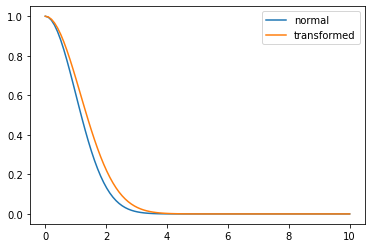

In [24]:
plt.plot(x,y1,label='normal')
plt.plot(x,y2,label='transformed')
plt.legend()
plt.show()